In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

data = yf.download("^NSEI", start="2015-01-01", end="2025-01-01")

print(data.head())


[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open  Volume
Ticker            ^NSEI        ^NSEI        ^NSEI        ^NSEI   ^NSEI
Date                                                                  
2015-01-02  8395.450195  8410.599609  8288.700195  8288.700195  101900
2015-01-05  8378.400391  8445.599609  8363.900391  8407.950195  118200
2015-01-06  8127.350098  8327.849609  8111.350098  8325.299805  172800
2015-01-07  8102.100098  8151.200195  8065.450195  8118.649902  164100
2015-01-08  8234.599609  8243.500000  8167.299805  8191.399902  143800


In [2]:
data["MA10"] = data["Close"].rolling(10).mean()
data["MA50"] = data["Close"].rolling(50).mean()
data["Returns"] = data["Close"].pct_change()
data["Volatility"] = data["Returns"].rolling(10).std()

data = data.dropna()

print(data.head())


Price             Close         High          Low         Open  Volume  \
Ticker            ^NSEI        ^NSEI        ^NSEI        ^NSEI   ^NSEI   
Date                                                                     
2015-03-17  8723.299805  8742.549805  8630.799805  8689.099609  177000   
2015-03-18  8685.900391  8747.250000  8664.000000  8742.900391  156400   
2015-03-19  8634.650391  8788.200195  8614.650391  8749.450195  163500   
2015-03-20  8570.900391  8627.900391  8553.000000  8627.900391  174600   
2015-03-23  8550.900391  8608.349609  8540.549805  8591.549805  150700   

Price              MA10         MA50   Returns Volatility  
Ticker                                                     
Date                                                       
2015-03-17  8780.560059  8669.166973  0.010442   0.009786  
2015-03-18  8749.525098  8674.975977 -0.004287   0.009476  
2015-03-19  8720.725098  8680.100977 -0.005900   0.009377  
2015-03-20  8684.040137  8688.971982 -0.007383 

In [3]:
features = ["Close", "MA10", "MA50", "Returns", "Volatility"]
dataset = data[features]


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

X, y = [], []
window_size = 60

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i])
    y.append(scaled_data[i, 0])  # predict Close price

X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# reshape for ML models
X_train_lr = X_train.reshape(X_train.shape[0], -1)
X_test_lr = X_test.reshape(X_test.shape[0], -1)

print(X_train.shape, X_test.shape)


(1880, 60, 5) (470, 60, 5)


In [5]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train)

predictions = lr_model.predict(X_test_lr)

print("Linear Regression training complete")


Linear Regression training complete


In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [5, 10, None]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error"
)

grid_search.fit(X_train_lr, y_train)

best_rf = grid_search.best_estimator_
rf_predictions = best_rf.predict(X_test_lr)

print("Best RF params:", grid_search.best_params_)


Best RF params: {'max_depth': 5, 'n_estimators': 50}


In [8]:
from sklearn.svm import SVR

param_grid = {
    "C": [1, 10],
    "gamma": ["scale", "auto"]
}

svm = SVR()

grid_svm = GridSearchCV(svm, param_grid, cv=3)
grid_svm.fit(X_train_lr, y_train)

best_svm = grid_svm.best_estimator_
svm_predictions = best_svm.predict(X_test_lr)

print("Best SVM params:", grid_svm.best_params_)


Best SVM params: {'C': 1, 'gamma': 'auto'}


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm_model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

lstm_predictions = lstm_model.predict(X_test)

print("LSTM training complete")


2026-02-11 16:54:42.092085: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-11 16:54:42.093689: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-11 16:54:42.159781: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-11 16:54:43.539168: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Epoch 1/10


/home/tejasnikas122/project/nifty_ml_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0037 - val_loss: 7.8251e-04
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.3015e-04 - val_loss: 5.3815e-04
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.6627e-04 - val_loss: 5.7962e-04
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.3028e-04 - val_loss: 4.2123e-04
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.9406e-04 - val_loss: 3.7989e-04
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.7049e-04 - val_loss: 3.4215e-04
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.5536e-04 - val_loss: 2.9778e-04
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4078e-04 - val_loss: 2.6204e-04
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2246e-04 - val_loss: 2.4392e-04
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.3901e-04 - val_loss: 2.2062e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
LSTM training complete


                        MSE      RMSE        R²      SMAPE
Linear Regression  0.000098  0.009892  0.994445   0.939221
Random Forest      0.039268  0.198162 -1.229449  21.607754
SVM                0.013144  0.114647  0.253758  13.886912
LSTM               0.000675  0.025972  0.961702   2.485230


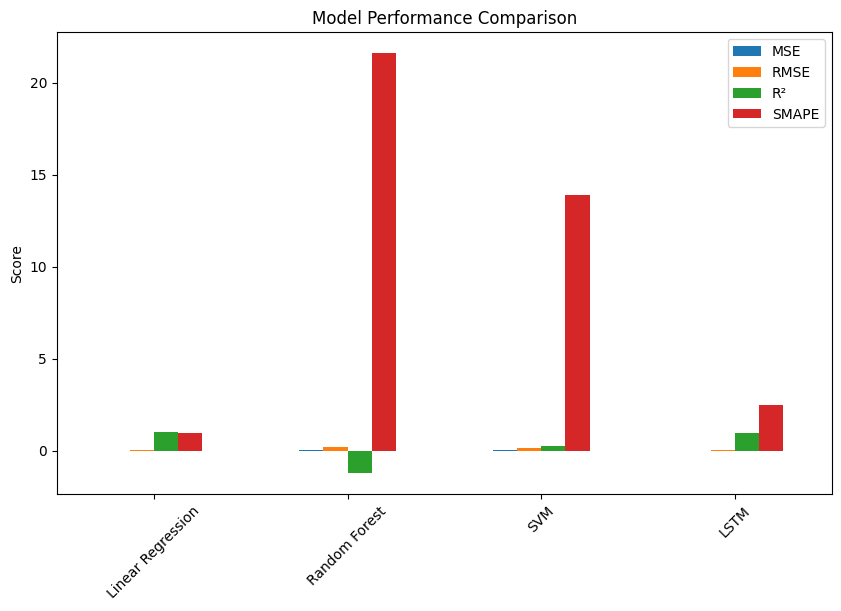

In [10]:
from sklearn.metrics import mean_squared_error, r2_score

def smape(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted).flatten()
    return 100/len(actual) * np.sum(
        2 * np.abs(predicted - actual) /
        (np.abs(actual) + np.abs(predicted) + 1e-8)
    )

results = {}

models = {
    "Linear Regression": predictions,
    "Random Forest": rf_predictions,
    "SVM": svm_predictions,
    "LSTM": lstm_predictions.flatten()
}

for name, pred in models.items():
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred)
    smape_value = smape(y_test, pred)

    results[name] = [mse, rmse, r2, smape_value]

comparison_df = pd.DataFrame(
    results,
    index=["MSE", "RMSE", "R²", "SMAPE"]
).T

print(comparison_df)

comparison_df.plot(kind="bar", figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()


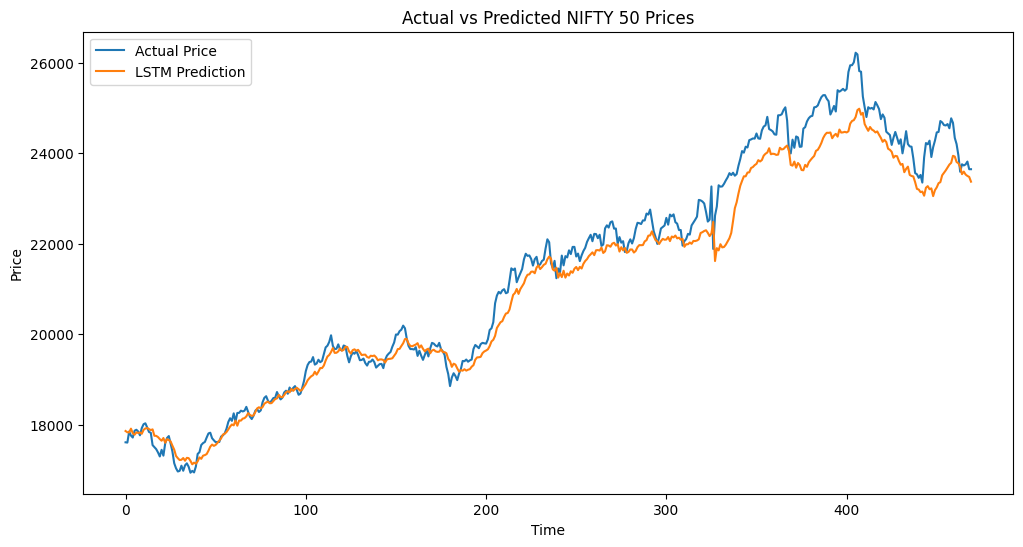

In [12]:
# Convert scaled predictions back to real prices

def inverse_transform(pred):
    dummy = np.zeros((len(pred), dataset.shape[1]))
    dummy[:, 0] = pred
    return scaler.inverse_transform(dummy)[:, 0]

real_y = inverse_transform(y_test)
real_lr = inverse_transform(predictions)
real_rf = inverse_transform(rf_predictions)
real_svm = inverse_transform(svm_predictions)
real_lstm = inverse_transform(lstm_predictions.flatten())

plt.figure(figsize=(12,6))
plt.plot(real_y, label="Actual Price")
plt.plot(real_lstm, label="LSTM Prediction")
plt.title("Actual vs Predicted NIFTY 50 Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
